<a href="https://www.kaggle.com/code/vikarna/airbnb-price-prediction?scriptVersionId=94687578" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Business Statement



This analysis will highlight specific elements of the "Seattle Airbnb Listing" Dataset from 2018 which features 7,576 listings with 18 variables, scraped and maintained by Tom Slee, and available for download on Kaggle.

In this fun and hopefully insightful exploration, we will begin by examining the unrefined data and perform any necessary tidying of the dataset. We will then determine which features provide most insight into price prediction and remove those that only serve to add noise. Data visualization and exploratory data analysis will then be performed on the tidied dataset to inform our modeling. Several machine learning algorithms will be applied to improve our RMSE (the root mean square error) from our baseline to our final model.

Data Preparation and Required Packages:
We will begin by loading the following libraries: tidyverse, readr, data.table, caret, lubridate, glmnet, scales, stringr, dplyr, ggmap, ggcorrplot, treemapify, rpart, nnet, formatR, rmarkdown, and knitr with the "pacman" package. (If a package below is missing, p_load will automatically download it from CRAN).

In [1]:
if(!require(pacman)) install.packages("pacman", repos = "http://cran.us.r-project.org")
library(pacman)
pacman::p_load(tidyverse, readr, data.table, caret, lubridate, 
               ggthemes, ggplot2, glmnet, scales, stringr, dplyr, ggmap, ggcorrplot, 
               treemapify, rpart, nnet, formatR, rmarkdown, knitr)
library(ggmap)

Loading required package: pacman



In [15]:
list.files(path = "../input", recursive = TRUE)

[1] "airbnb/airbnb_excel.csv"

reading the data airbnb 

In [3]:
airbnb <- read.csv("../input/airbnb/airbnb_excel.csv")

head(airbnb)

,room_type,address,reviews,overall_satisfaction,accommodates,bedrooms,price,latitude,longitude,name
,<fct>,<fct>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>
1,Entire home/apt,Seattle,21,5.000000,8,4,250,47.61082,-122.2908,"Casa Madrona - Urban Oasis, 1 block from the Park!"
2,Entire home/apt,Seattle,1,4.841226,4,2,100,47.52985,-122.2758,Sweet Seattle Urban Homestead 2 Bdr
3,Private room,Seattle,63,4.500000,2,1,82,47.68780,-122.3134,Sunrise in Seattle Master Suite
4,Entire home/apt,Seattle,462,5.000000,2,0,49,47.52398,-122.3599,"Cozy Studio, min. to downtown -WiFi"
5,Entire home/apt,Seattle,134,4.500000,2,1,90,47.65411,-122.3376,"Fab, private seattle urban cottage!"
6,Private room,Seattle,130,4.500000,2,1,65,47.55017,-122.3194,Glorious sun room w/ memory foambed


In [4]:
dim(airbnb)


# There are 7576 observations and 10 features

str(airbnb)

[1] 7576   10

'data.frame':	7576 obs. of  10 variables:
 $ room_type           : Factor w/ 3 levels "Entire home/apt",..: 1 1 2 1 1 2 2 1 1 1 ...
 $ address             : Factor w/ 14 levels "Bellevue","Bothell",..: 11 11 11 11 11 11 11 11 11 11 ...
 $ reviews             : int  21 1 63 462 134 130 401 35 36 76 ...
 $ overall_satisfaction: num  5 4.84 4.5 5 4.5 ...
 $ accommodates        : int  8 4 2 2 2 2 2 4 3 4 ...
 $ bedrooms            : int  4 2 1 0 1 1 1 2 2 1 ...
 $ price               : int  250 100 82 49 90 65 78 165 95 115 ...
 $ latitude            : num  47.6 47.5 47.7 47.5 47.7 ...
 $ longitude           : num  -122 -122 -122 -122 -122 ...
 $ name                : Factor w/ 7376 levels "-  1,450 sq ft - Queen Anne View - sleeps 11",..: 1525 6515 6464 2394 2887 3102 2738 6536 6596 6611 ...


In [5]:
sum(is.na(airbnb)) # missing values

[1] 0

In [6]:
colSums(is.na(airbnb))

room_type              address              reviews 
                   0                    0                    0 
overall_satisfaction         accommodates             bedrooms 
                   0                    0                    0 
               price             latitude            longitude 
                   0                    0                    0 
                name 
                   0

# EDA

In [7]:
airbnb %>% select(address) %>% distinct()

address
<fct>
Seattle
Kirkland
Bellevue
Redmond
Mercer Island
Renton
Medina
Newcastle
Yarrow Point


In [8]:
city_list <-airbnb %>% group_by(address) %>% summarize(listing_sum = n()) %>%
  arrange(-listing_sum)
city_list

address,listing_sum
<fct>,<int>
Seattle,6791
Bellevue,322
Kirkland,202
Redmond,110
Mercer Island,50
Newcastle,49
Renton,39
Medina,4
Bothell,2


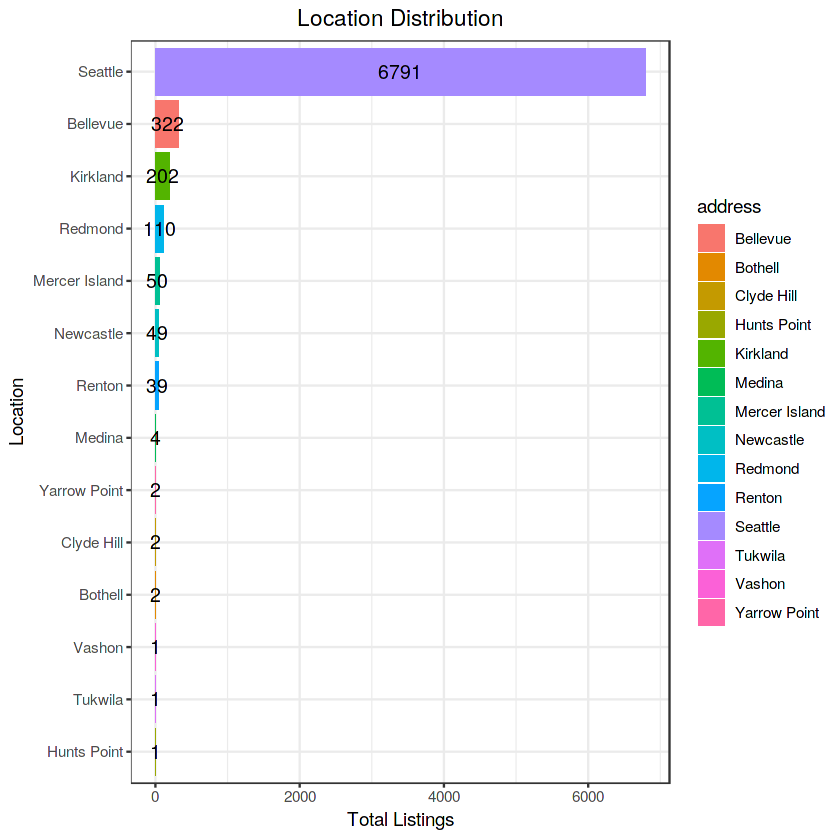

In [9]:
city_list %>% 
  ggplot(aes(x = reorder(address, listing_sum), y = listing_sum, 
                         fill = address, label = listing_sum))+
                         geom_bar(stat = "identity")+
                         ggtitle("Location Distribution")+
                         xlab("Location")+
                         ylab("Total Listings")+
                         coord_flip()+
                         geom_text(size = 4, 
                                   position = position_stack(vjust = 0.5))+
                         theme_bw()+
                         theme(plot.title = element_text(hjust = 0.5))

**Downtown Seattle has highest listings among the data given.**

Correlogram:
Remove non-numeric features:



In [10]:
airbnb_num <-airbnb %>% select(-c(address, room_type,name))

In [11]:
airbnb_cor <-cor(airbnb_num)

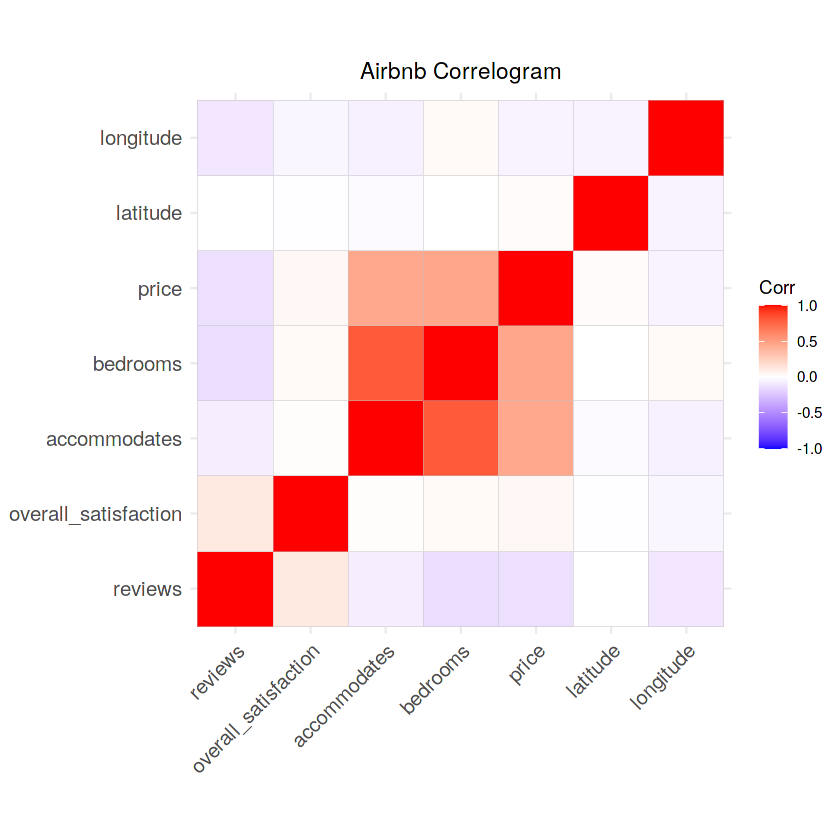

In [12]:
ggcorrplot(airbnb_cor)+
  labs(title = "Airbnb Correlogram")+
  theme(plot.title = element_text(hjust = 0.5))

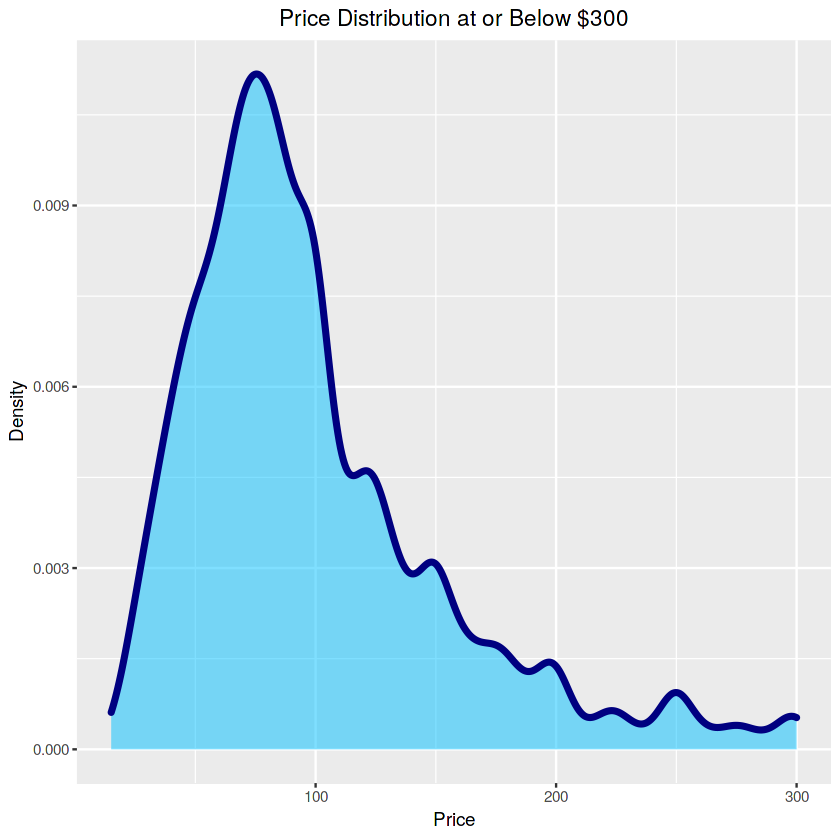

In [13]:
airbnb %>% filter(price <=300) %>% ggplot(aes(price))+
  geom_density(fill = "deepskyblue", size = 1.5, color = "navyblue", alpha = 0.5)+
  xlab("Price")+
  ylab("Density")+
  ggtitle("Price Distribution at or Below $300")+
  theme(plot.title = element_text(hjust = 0.5))

**Interestingly prices are right skewed and seemed be more concentrated around $70-$100 per night for most the listings.Hence budget properties are in demand and also available based on the data**

Geographical Scatterplot of Prices in Seattle:
Let's use the ggmap package to load a map of Seattle and visualize which areas are more expensive than others.

Create the map using stamenmap:

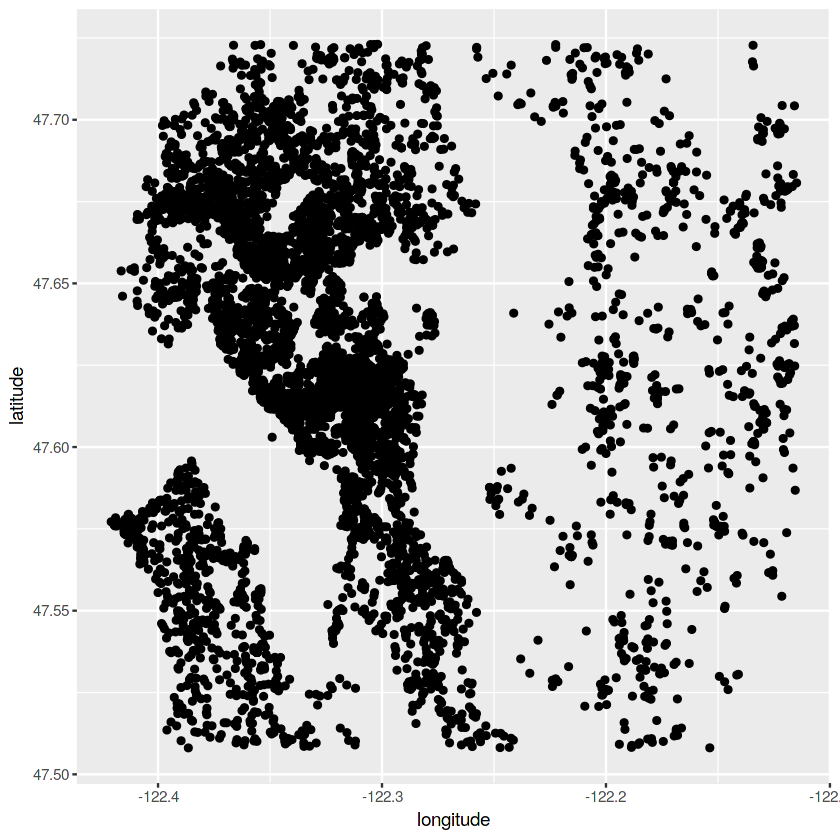

In [35]:
ggplot() +
  geom_point(data=airbnb, aes(x=longitude, y=latitude))


It does not appear that one area is significantly more expensive than another and that most prices are less than $1000, though outliers may be skewing our data. As such, let's attempt to refine our heatmap by filtering the data.

In [17]:
city_price <-airbnb %>% group_by(address) %>% 
  summarize(mean_price = mean(price),
            listing_sum = n()) %>%
  arrange(-mean_price) %>% mutate(mean_price = sprintf("%0.1f", mean_price))
# Coerce the "mean_price" to integer:
city_price$mean_price <-as.integer(city_price$mean_price)


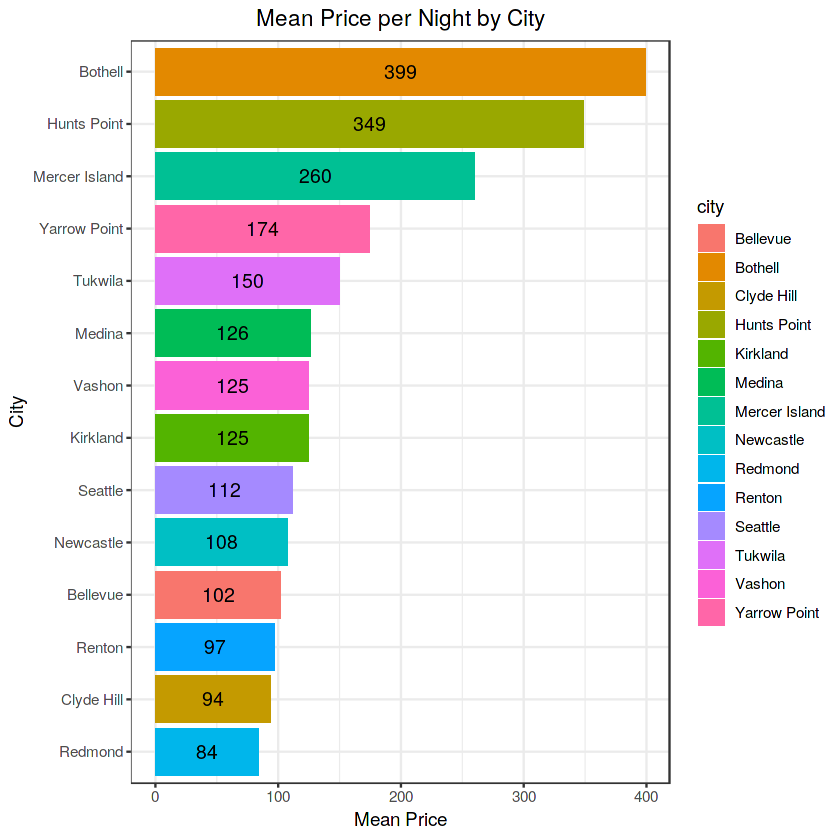

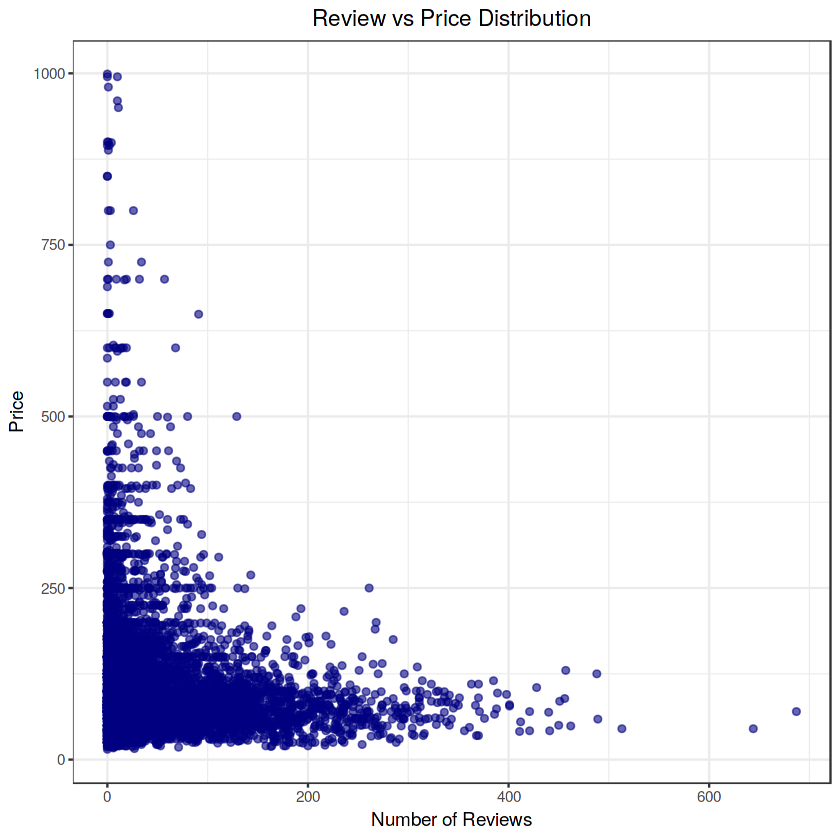

In [18]:
airbnb %>% filter(price <= 1000) %>% 
  ggplot(aes(x = reviews, y = price))+ 
  geom_point(color="navyblue", alpha = 0.6, size = 1.5)+
  xlab("Number of Reviews")+
  ylab("Price")+
  ggtitle("Review vs Price Distribution")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

**Number of Reviews seems to be concentrated below 200 zone.Very few have more than 400 reviews**

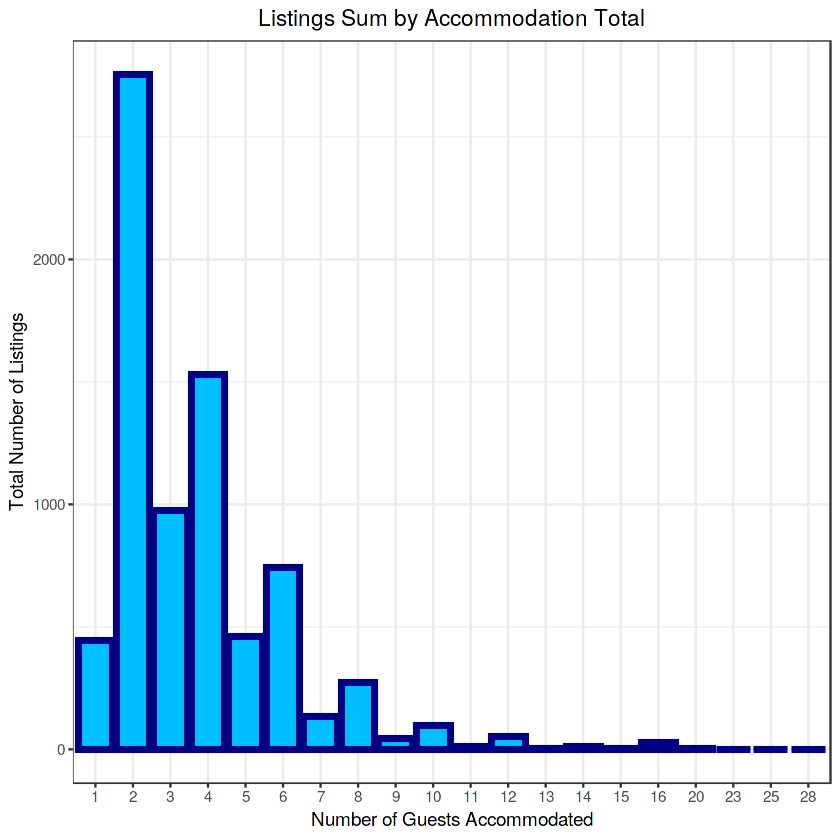

In [19]:
airbnb %>% group_by(accommodates) %>% 
  summarize(sum_acc = length(accommodates)) %>% 
  ggplot(aes(x = factor(accommodates), y = sum_acc))+
  geom_bar(stat = "identity", color = "navyblue", fill = "deepskyblue", size = 1.5)+
  xlab("Number of Guests Accommodated")+
  ylab("Total Number of Listings")+
  ggtitle("Listings Sum by Accommodation Total")+
  theme_bw()+
  theme(plot.title = element_text(hjust = 0.5))

**2 person accomodation is the highest among them, followed by 4 guests accomodated. Very likely couples or families look for more Air BnB properties compared to other groups in general.**

# Modeling

Modeling:
Partition Airbnb Combined & Test Sets for the Final Model:

airbnb_combined will be used to fit the Final Model as it is equal to the sum of the training and validation sets and equal to 90% of the total data. airbnb_test, comprised of the remaining 10% of the data, will be used as the test set for the final model.

In [20]:
# Set the seed for reproducibility:
set.seed(123, sample.kind = "Rounding")
test_index <- createDataPartition(y = airbnb$price, times = 1, p = 0.1, list = F)
airbnb_combined <- airbnb[-test_index,]
airbnb_test <- airbnb[test_index,]
# Remove test_index:
rm(test_index)

Warning message in set.seed(123, sample.kind = "Rounding"):
“non-uniform 'Rounding' sampler used”


Split Training and Validation Sets from airbnb_combined to train our models: airbnb_train will constitute 80% and validation the remaining 20% of airbnb_combined.

The Loss Function / RMSE is defined as follows:

Results will be based on calculating the Root Mean Square Error on the test set. The RMSE weighs large errors more heavily and tends to be the preferred measurement of error in regression models when large errors are undesirable.



In [22]:
RMSE <-function(true_ratings, predicted_ratings){
  sqrt(mean((true_ratings - predicted_ratings)^2))
}

In [23]:
airbnb_train_median <-median(airbnb_train$price)

In [24]:
MM_RMSE <-RMSE(validation$price, airbnb_train_median)
results_table <-tibble(Model_Type = "Baseline Median", 
                       RMSE = MM_RMSE) %>% 
  mutate(RMSE = sprintf("%0.2f", RMSE))
knitr::kable(results_table)



|Model_Type      |RMSE  |
|:---------------|:-----|
|Baseline Median |99.05 |

Vectorize the optimal formula that will be used for most Models:
The formula has been determined by the above EDA as well as experimentation on the training models. Additionally, the formula will reduce lines of code.

# Linear Regression

In [25]:
airbnb_form <-price ~ overall_satisfaction + reviews + bedrooms +
  accommodates + latitude + longitude

linear_reg <- lm(airbnb_form ,data=airbnb_train)

summary(linear_reg)



Call:
lm(formula = airbnb_form, data = airbnb_train)

Residuals:
   Min     1Q Median     3Q    Max 
-350.9  -35.9  -11.0   19.7 5661.3 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.550e+04  3.689e+03  -4.201  2.7e-05 ***
overall_satisfaction  2.042e+01  6.328e+00   3.226 0.001262 ** 
reviews              -1.645e-01  2.458e-02  -6.693  2.4e-11 ***
bedrooms              3.292e+01  2.672e+00  12.321  < 2e-16 ***
accommodates          1.168e+01  1.139e+00  10.249  < 2e-16 ***
latitude              8.548e+01  3.418e+01   2.501 0.012408 *  
longitude            -9.289e+01  2.789e+01  -3.331 0.000871 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 116.6 on 5445 degrees of freedom
Multiple R-squared:  0.2113,	Adjusted R-squared:  0.2104 
F-statistic: 243.1 on 6 and 5445 DF,  p-value: < 2.2e-16


In [26]:
lm_preds <-predict(linear_reg, airbnb_test)

LM_RMSE <- RMSE(airbnb_test$price,lm_preds)

LM_RMSE

[1] 75.53668

# Random Forest

In [27]:
library(caTools)
library(randomForest)

rf <- randomForest(airbnb_form, data =airbnb_train)

rf_pred <- predict(rf,airbnb_test)

RF_RMSE <- RMSE(airbnb_test$price,rf_pred)


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin




In [29]:
RF_RMSE

[1] 68.78499

# Elastic Regression

Elastic net regression combines the properties of ridge and lasso regression. It works by penalizing the model using both the 1l2-norm1 and the 1l1-norm1. The model can be easily built using the caret package, which automatically selects the optimal value of parameters alpha and lambda.

The first line of code creates the training control object train_cont which specifies how the repeated cross validation will take place. The second line builds the elastic regression model in which a range of possible alpha and lambda values are tested and their optimum value is selected. The argument tuneLength specifies that 10 different combinations of values for alpha and lambda are to be tested.


In [30]:
train_cont <- trainControl(method = "repeatedcv",
                              number = 10,
                              repeats = 5,
                              search = "random",
                              verboseIter = TRUE)


elastic_reg <- train(airbnb_form ,
                           data = airbnb_train,
                           method = "glmnet",
                           preProcess = c("center", "scale"),
                           tuneLength = 10,
                           trControl = train_cont)


+ Fold01.Rep1: alpha=0.61876, lambda=0.516570 
- Fold01.Rep1: alpha=0.61876, lambda=0.516570 
+ Fold01.Rep1: alpha=0.17726, lambda=0.437276 
- Fold01.Rep1: alpha=0.17726, lambda=0.437276 
+ Fold01.Rep1: alpha=0.24892, lambda=0.088548 
- Fold01.Rep1: alpha=0.24892, lambda=0.088548 
+ Fold01.Rep1: alpha=0.37148, lambda=6.289742 
- Fold01.Rep1: alpha=0.37148, lambda=6.289742 
+ Fold01.Rep1: alpha=0.02891, lambda=0.722717 
- Fold01.Rep1: alpha=0.02891, lambda=0.722717 
+ Fold01.Rep1: alpha=0.46466, lambda=1.991963 
- Fold01.Rep1: alpha=0.46466, lambda=1.991963 
+ Fold01.Rep1: alpha=0.67687, lambda=0.001751 
- Fold01.Rep1: alpha=0.67687, lambda=0.001751 
+ Fold01.Rep1: alpha=0.06110, lambda=0.045077 
- Fold01.Rep1: alpha=0.06110, lambda=0.045077 
+ Fold01.Rep1: alpha=0.28167, lambda=4.443232 
- Fold01.Rep1: alpha=0.28167, lambda=4.443232 
+ Fold01.Rep1: alpha=0.99661, lambda=3.098198 
- Fold01.Rep1: alpha=0.99661, lambda=3.098198 
+ Fold02.Rep1: alpha=0.61876, lambda=0.516570 
- Fold02.Rep1

In [31]:

ela_reg_pred <- predict(elastic_reg,airbnb_test)

ela_reg_RMSE <- RMSE(airbnb_test$price,ela_reg_pred)

In [32]:
res_table <- data.frame(LM_RMSE,RF_RMSE,ela_reg_RMSE)

colnames(res_table) <- c("Linear Regression" , "Random Forest",'Elastic Regression')


res_table

Linear Regression,Random Forest,Elastic Regression
<dbl>,<dbl>,<dbl>
75.53668,68.78499,75.51528


**From the above we can see that Linear Regression seems to be the best model in terms of RMSE**